In [32]:
#12sc & unig represent commercial algorithms that extracted ECG parameter from PT XL whereas ecg deli is an matlab based open source algorithm
#Features known to change with aging ECG: P_Dur_Global, PR_Int_Global, PQ_Int_Global, QRS_Dur_Global, QRS_AxisFront_Global, QT_Int_Global, QT_IntCorr_Global 

import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import numpy as np

In [33]:
# Read CSV of 3 different Features Sets of PTB-XL, Metadata (including age), & Disease Prediction
model_predictions = pd.read_csv('results_ptbXL_age_6diseases.csv')
metadata = pd.read_csv('ptbxl_database.csv')

# Read Feature Dataset and extract PR interval, QRS duration (both as global parameter for all leads) and the area for the T-wave particularly for lead V1 
Features1 = pd.read_csv('12sl_features.csv')
Features1 = Features1[['ecg_id', 'PR_Int_Global', 'QRS_Dur_Global', 'T_Area_V1']] 

Features2 = pd.read_csv('unig_features.csv')
Features2 = Features2[['ecg_id', 'PR_Int_Global', 'QRS_Dur_Global']]

Features3 = pd.read_csv('ecgdeli_features.csv')
Features3 = Features3[['ecg_id','PR_Int_Global', 'QRS_Dur_Global']]

Features1.head()

ecg_id  PR_Int_Global  QRS_Dur_Global  T_Area_V1
0       1          154.0            80.0      0.384
1   21803          144.0           120.0     -1.715
2   21804            NaN           116.0     -1.824
3   21805          184.0           100.0      1.377
4   21806          198.0            90.0      0.308

In [34]:
#Get Model Predictions
model_predictions = model_predictions.drop(0)
model_predictions['ecg_id'] = model_predictions['ECG_id'].str[:-3].astype(int)
model_predictions = model_predictions[['ecg_id', '1dAVb', 'RBBB', 'LBBB']]
model_predictions = model_predictions.rename(columns={'1dAVb': '1dAV_prediction'})
model_predictions = model_predictions.rename(columns={'RBBB': 'RBBB_prediction'})
model_predictions = model_predictions.rename(columns={'LBBB': 'LBBB_prediction'})
model_predictions.head()

ecg_id  1dAV_prediction  RBBB_prediction  LBBB_prediction
1    6217     7.041947e-06     6.753972e-09     4.295944e-09
2    6540     3.211741e-02     1.302835e-05     8.808085e-01
3    6910     1.324551e-02     1.277351e-05     6.374598e-05
4    6481     2.990983e-03     3.881286e-08     2.113784e-08
5    6948     2.391041e-08     9.798152e-12     9.498216e-12

In [35]:
#Get the data where human validated first degree av block, complete left bundle brach block & complete right bundle branch block are present
metadata['scp_codes'] = metadata['scp_codes'].apply(ast.literal_eval)
metadata['LBBB'] = metadata.apply(lambda row: 1 if ('CLBBB' in row['scp_codes'] and row['scp_codes']['CLBBB'] == 100 and row['validated_by_human']) else 0, axis=1)
metadata['RBBB'] = metadata.apply(lambda row: 1 if ('CRBBB' in row['scp_codes'] and row['scp_codes']['CRBBB'] == 100 and row['validated_by_human']) else 0, axis=1)
metadata['1dAV'] = metadata.apply(lambda row: 1 if ('1AVB' in row['scp_codes'] and row['scp_codes']['1AVB'] == 100 and row['validated_by_human']) else 0, axis=1)
metadata = metadata[['ecg_id', 'age', 'sex', '1dAV', 'RBBB', 'LBBB']]
# Filter out rows where 'age' is missing (NaN)
metadata = metadata.dropna(subset=['age'])
# Replace all values of 300 with 90 in the 'age' column
metadata['age'] = metadata['age'].replace(300, 9)
# Rename the 'age' column to 'chronological_age'
metadata = metadata.rename(columns={'age': 'chronological_age'})
metadata.head()

ecg_id  chronological_age  sex  1dAV  RBBB  LBBB
0       1               56.0    1     0     0     0
1       2               19.0    0     0     0     0
2       3               37.0    1     0     0     0
3       4               24.0    0     0     0     0
4       5               19.0    1     0     0     0

In [36]:
#merge the prepared df for further processing
meta_prediction = pd.merge(model_predictions, metadata, on='ecg_id', how='left')
meta_prediction_feature1 = pd.merge(meta_prediction, Features1, on='ecg_id', how='left')
meta_prediction_feature2 = pd.merge(meta_prediction, Features2, on='ecg_id', how='left')
meta_prediction_feature3 = pd.merge(meta_prediction, Features3, on='ecg_id', how='left')
#remove all patients with ages under 16 since there were not included during training of the neural network and pediatric heart are physiologically very different

meta_prediction_feature1 = meta_prediction_feature1[meta_prediction_feature1['chronological_age'] > 16]
meta_prediction_feature2 = meta_prediction_feature2[meta_prediction_feature2['chronological_age'] > 16]
meta_prediction_feature3 = meta_prediction_feature3[meta_prediction_feature3['chronological_age'] > 16]
meta_prediction_feature3.head()

ecg_id  1dAV_prediction  RBBB_prediction  LBBB_prediction  \
0    6217     7.041947e-06     6.753972e-09     4.295944e-09   
1    6540     3.211741e-02     1.302835e-05     8.808085e-01   
2    6910     1.324551e-02     1.277351e-05     6.374598e-05   
3    6481     2.990983e-03     3.881286e-08     2.113784e-08   
4    6948     2.391041e-08     9.798152e-12     9.498216e-12   

   chronological_age  sex  1dAV  RBBB  LBBB  PR_Int_Global  QRS_Dur_Global  
0               67.0    1     0     0     0          284.0           166.0  
1               71.0    0     0     0     0          364.0           220.0  
2               58.0    0     1     0     0          302.0           188.0  
3               76.0    0     0     0     0          286.0           138.0  
4               23.0    1     0     0     0          250.0           142.0

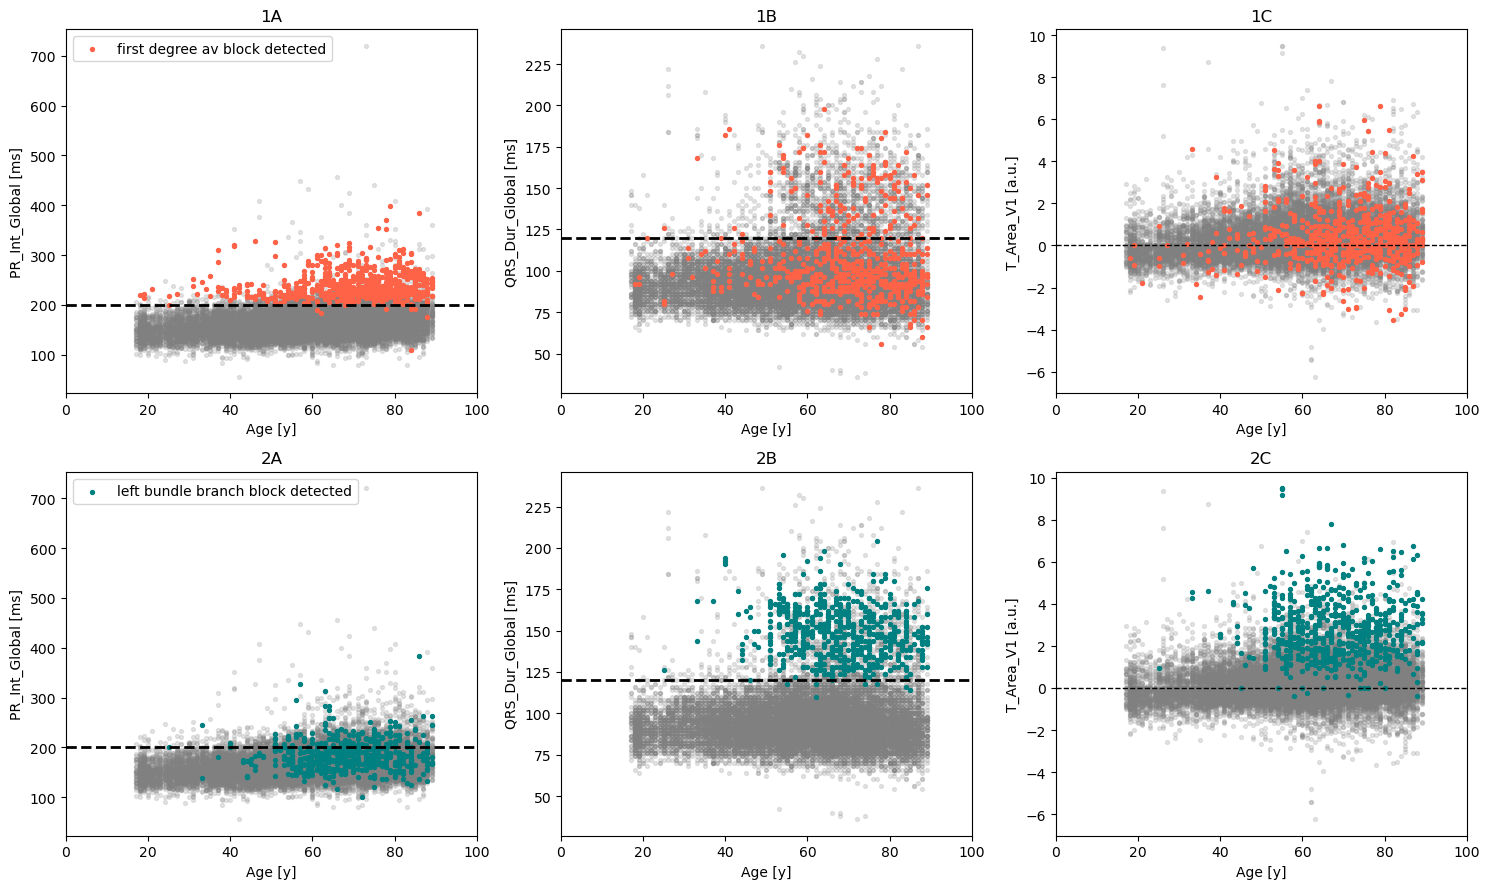

In [37]:
# Extract feature columns
feature_columns = meta_prediction_feature1.columns.difference(['ecg_id', 'ECG_Age', 
                                                               'chronological_age', 'sex', 'RBBB', 'LBBB', '1dAV',
                                                             '1dAV_prediction', 'RBBB_prediction', 'LBBB_prediction'])#, 'QT_IntCorr_Global'])
# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=len(feature_columns), figsize=(15, 9))
AVb1 = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
LBBB = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]

vertical_line_positions = [200, 120, 0]
units = ['[ms]', '[ms]', '[a.u.]']
# Define labels
labels = [['1A', '2A'], ['1B', '2B'], ['1C', '2C']]

# Iterate through feature columns and create scatter plots
for i, feature in enumerate(feature_columns):
    
    # Scatter plot for chronological_age
    axes[0, i].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.2, s=8, color='grey')
    axes[0, i].scatter(AVb1['chronological_age'], AVb1[feature], alpha=1.0, s=8, color='tomato', label='first degree av block detected')
    axes[0, i].set_xlabel('Age [y]')
    axes[0, i].set_ylabel(f'{feature} {units[i]}')
    axes[0, i].set_xlim(0, 100)  # Set x-axis range to 0-100
    axes[0, i].set_title(labels[i][0])
    if i == 0:
        axes[0,i].legend()
    # Scatter plot for chronological_age
    axes[1, i].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.2, s=8, color='grey')
    axes[1, i].scatter(LBBB['chronological_age'], LBBB[feature], alpha=1.0, s=8, color='teal', label='left bundle branch block detected')
    axes[1, i].set_xlabel('Age [y]')
    axes[1, i].set_ylabel(f'{feature} {units[i]}')
    axes[1, i].set_xlim(0, 100)  # Set x-axis range to 0-100
    axes[1, i].set_title(labels[i][1])
    if i == 0:
        axes[1,i].legend()

    # Threshold line
    linewidth = 2 if i < 2 else 1  # Set double linewidth for the first two threshold lines
    axes[0, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)
    axes[1, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_GE_algorithmus_16_90.png', dpi=400)


In [38]:
# % for AVb1 
AVb1_above_threshold = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] > 0.5) & (meta_prediction_feature1['PR_Int_Global'] > 200)]
AVb1_all_high_confidences = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] > 0.5)]
len(AVb1_above_threshold)/len(AVb1_all_high_confidences) 

0.9597523219814241

In [39]:
#% for LBBB
AVb1_above_threshold = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.5) & (meta_prediction_feature1['QRS_Dur_Global'] > 120)]
AVb1_all_high_confidences = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.5)]
len(AVb1_above_threshold)/len(AVb1_all_high_confidences) 

0.986046511627907

In [40]:
AVb1_above_threshold = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.5) & (meta_prediction_feature1['T_Area_V1'] > 0)]
AVb1_all_high_confidences = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.5)]
len(AVb1_above_threshold)/len(AVb1_all_high_confidences) 

0.9813953488372092

In [41]:
# Extract feature columns
feature_columns = meta_prediction_feature1.columns.difference(['ecg_id', 'ECG_Age', 
                                                               'chronological_age', 'sex', 'RBBB', 'LBBB', '1dAV',
                                                             '1dAV_prediction', 'RBBB_prediction', 'LBBB_prediction'])#, 'QT_IntCorr_Global'])
# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=len(feature_columns), figsize=(15, 9))
AVb1_high = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
AVb1_low = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] >0.124) & (meta_prediction_feature1['1dAV_prediction'] <0.5)]
LBBB_high = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]
LBBB_low = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['LBBB_prediction'] <0.5)]


vertical_line_positions = [200, 120, 0]
units = ['[ms]', '[ms]', '[a.u.]']
# Define labels
labels = [['1A', '2A'], ['1B', '2B'], ['1C', '2C']]

# Iterate through feature columns and create scatter plots
for i, feature in enumerate(feature_columns):
    
    # Scatter plot for chronological_age
    axes[0, i].scatter(meta_prediction_feature1['1dAV_prediction'], meta_prediction_feature1[feature], alpha=0.2, s=8, color='grey')
    axes[0, i].scatter(AVb1_high['1dAV_prediction'], AVb1_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
    axes[0, i].scatter(AVb1_low['1dAV_prediction'], AVb1_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')

    axes[0, i].set_xlabel('disease prediction [a.u.]')
    axes[0, i].set_ylabel(f'{feature} {units[i]}')
    axes[0, i].set_title(labels[i][0])
    if i == 0:
        axes[0,i].legend()
    # Scatter plot for chronological_age
    axes[1, i].scatter(meta_prediction_feature1['LBBB_prediction'], meta_prediction_feature1[feature], alpha=0.2, s=8, color='grey')
    axes[1, i].scatter(LBBB_high['LBBB_prediction'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='LBBB high confidence')
    axes[1, i].scatter(LBBB_low['LBBB_prediction'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='LBBB low confidence')
    axes[1, i].set_xlabel('disease prediction [a.u.]')
    axes[1, i].set_ylabel(f'{feature} {units[i]}')
    axes[1, i].set_title(labels[i][1])
    if i == 0:
        axes[1,i].legend()

    # Threshold line
    linewidth = 2 if i < 2 else 1  # Set double linewidth for the first two threshold lines
    axes[0, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)
    axes[1, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_ESC_Story.png', dpi=400)



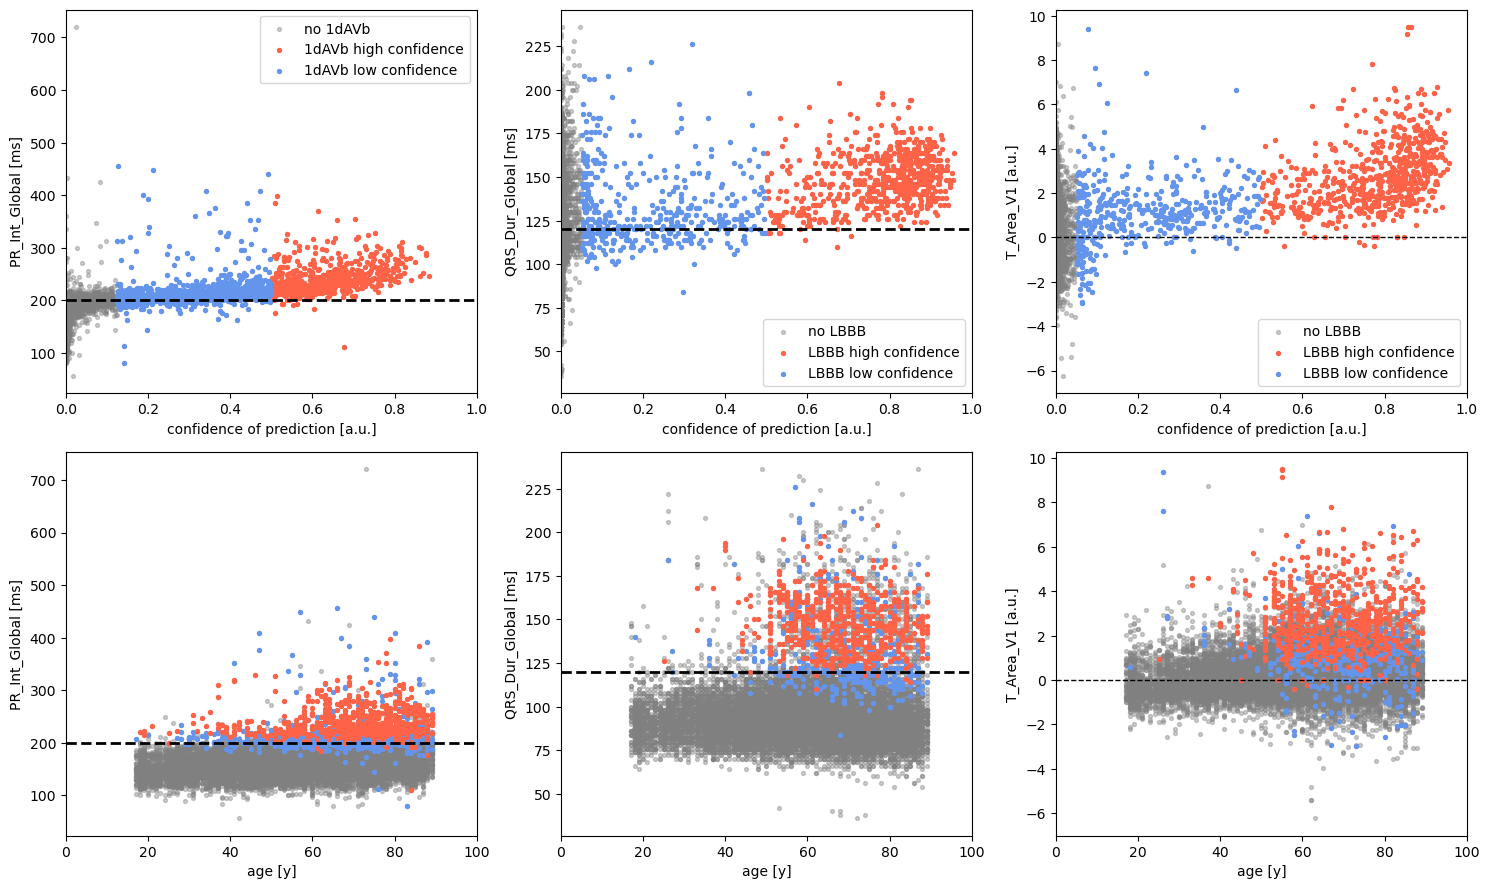

In [42]:
# Extract feature columns
feature_columns = meta_prediction_feature1.columns.difference(['ecg_id', 'ECG_Age', 
                                                               'chronological_age', 'sex', 'RBBB', 'LBBB', '1dAV',
                                                             '1dAV_prediction', 'RBBB_prediction', 'LBBB_prediction'])#, 'QT_IntCorr_Global'])
# Create subplots for each feature
fig, axes = plt.subplots(nrows=2, ncols=len(feature_columns), figsize=(15, 9))
AVb1_high = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
AVb1_low = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] >0.124) & (meta_prediction_feature1['1dAV_prediction'] <0.5)]
LBBB_high = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]
LBBB_low = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['LBBB_prediction'] <0.5)]

vertical_line_positions = [200, 120, 0]
units = ['[ms]', '[ms]', '[a.u.]']
# Define labels

# Iterate through feature columns and create scatter plots
for i, feature in enumerate(feature_columns):


    if i == 0:
                # Scatter plot for chronological_age
        axes[1, i].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey')
        axes[1, i].scatter(AVb1_low['chronological_age'], AVb1_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
        axes[1, i].scatter(AVb1_high['chronological_age'], AVb1_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
        axes[1, i].set_xlabel('age [y]')
        axes[1, i].set_ylabel(f'{feature} {units[i]}')
        axes[1, i].set_xlim(0, 100)  # Set x-axis range to 0-100
        #axes[1,i].legend(loc='upper right')
    else:
        # Scatter plot for chronological_age
        axes[1, i].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey')
        axes[1, i].scatter(LBBB_low['chronological_age'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='LBBB low confidence')
        axes[1, i].scatter(LBBB_high['chronological_age'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='LBBB high confidence')
        axes[1, i].set_xlabel('age [y]')
        axes[1, i].set_ylabel(f'{feature} {units[i]}')
        axes[1, i].set_xlim(0, 100)  # Set x-axis range to 0-100
        #axes[1, i].legend(loc='lower right')

    if i == 0:
        axes[0, i].scatter(meta_prediction_feature1['1dAV_prediction'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey', label='no 1dAVb')
        axes[0, i].scatter(AVb1_high['1dAV_prediction'], AVb1_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
        axes[0, i].scatter(AVb1_low['1dAV_prediction'], AVb1_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
        axes[0, i].set_xlabel('confidence of prediction [a.u.]')
        axes[0, i].set_xlim(0, 1)  # Set x-axis range to 0-1
        axes[0, i].set_ylabel(f'{feature} {units[i]}')
        axes[0,i].legend(loc='upper right')
    else:
        axes[0, i].scatter(meta_prediction_feature1['LBBB_prediction'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey', label='no LBBB')
        axes[0, i].scatter(LBBB_high['LBBB_prediction'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='LBBB high confidence')
        axes[0, i].scatter(LBBB_low['LBBB_prediction'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='LBBB low confidence')
        axes[0, i].set_xlabel('confidence of prediction [a.u.]')
        axes[0, i].set_xlim(0, 1)  # Set x-axis range to 0-1
        axes[0, i].set_ylabel(f'{feature} {units[i]}')
        axes[0,i].legend(loc='lower right')
    # Threshold line
    linewidth = 2 if i < 2 else 1  # Set double linewidth for the first two threshold lines
    axes[0, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)
    axes[1, i].axhline(y=vertical_line_positions[i], color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_GE_algorithmus_.png', dpi=500)


In [31]:
AVb1_high = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
AVb1_low = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] >0.124) & (meta_prediction_feature1['1dAV_prediction'] <0.5)]
LBBB_high = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]
LBBB_low = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['LBBB_prediction'] <0.5)]

ig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 7))
feature='PR_Int_Global'

axes[0].scatter(meta_prediction_feature1['1dAV_prediction'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey', label='no 1dAVb')
axes[0].scatter(AVb1_low['1dAV_prediction'], AVb1_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
axes[0].scatter(AVb1_high['1dAV_prediction'], AVb1_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
axes[0].set_xlabel('confidence of prediction [a.u.]')
axes[0].set_xlim(0, 1)  # Set x-axis range to 0-1
axes[0].set_ylim(0, 620)  
axes[0].set_ylabel('PR interval [ms]')
axes[0].legend(loc='upper right')

        # Scatter plot for chronological_age
axes[1].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey')
axes[1].scatter(AVb1_low['chronological_age'], AVb1_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
axes[1].scatter(AVb1_high['chronological_age'], AVb1_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
axes[1].set_xlabel('age [y]')
axes[1].set_ylim(0, 500)  
axes[1].set_ylabel('PR interval [ms]')
axes[1].set_xlim(16, 90)  # Set x-axis range to 0-100
#axes[1,i].legend(loc='upper right')


# Threshold line
linewidth = 2 
axes[0].axhline(y=200, color='black', linestyle='--', linewidth=linewidth)
axes[1].axhline(y=200, color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_GE_algorithmus_PR_Int.png', dpi=300)


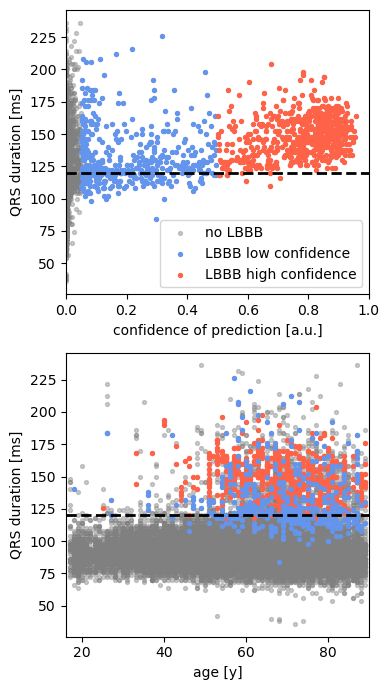

In [44]:
AVb1_high = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
AVb1_low = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] >0.124) & (meta_prediction_feature1['1dAV_prediction'] <0.5)]
LBBB_high = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]
LBBB_low = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['LBBB_prediction'] <0.5)]

ig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 7))
feature='QRS_Dur_Global'

axes[0].scatter(meta_prediction_feature1['LBBB_prediction'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey', label='no LBBB')
axes[0].scatter(LBBB_low['LBBB_prediction'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='LBBB low confidence')
axes[0].scatter(LBBB_high['LBBB_prediction'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='LBBB high confidence')
axes[0].set_xlabel('confidence of prediction [a.u.]')
axes[0].set_xlim(0, 1)  # Set x-axis range to 0-1
axes[0].set_ylabel('QRS duration [ms]')
axes[0].legend(loc='lower right')

        # Scatter plot for chronological_age
axes[1].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey')
axes[1].scatter(LBBB_high['chronological_age'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
axes[1].scatter(LBBB_low['chronological_age'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
axes[1].set_xlabel('age [y]')
axes[1].set_ylabel('QRS duration [ms]')
axes[1].set_xlim(16, 90)  # Set x-axis range to 0-100
#axes[1,i].legend(loc='upper right')


# Threshold line
linewidth = 2 
axes[0].axhline(y=120, color='black', linestyle='--', linewidth=linewidth)
axes[1].axhline(y=120, color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_GE_algorithmus_QRS_Dur.png', dpi=300)


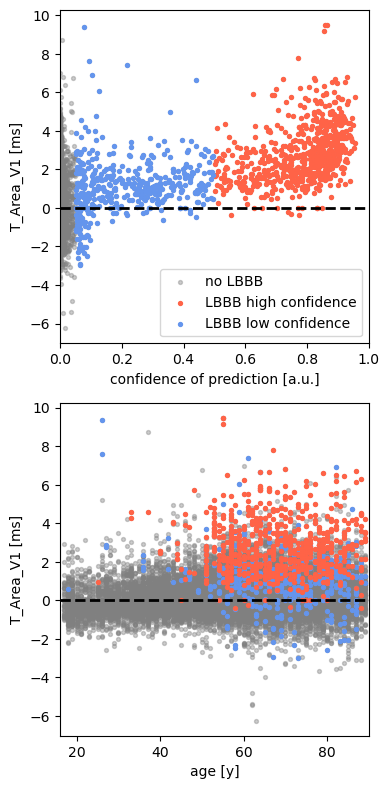

In [18]:
AVb1_high = meta_prediction_feature1[meta_prediction_feature1['1dAV_prediction'] >0.5]
AVb1_low = meta_prediction_feature1[(meta_prediction_feature1['1dAV_prediction'] >0.124) & (meta_prediction_feature1['1dAV_prediction'] <0.5)]
LBBB_high = meta_prediction_feature1[meta_prediction_feature1['LBBB_prediction'] > 0.5]
LBBB_low = meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['LBBB_prediction'] <0.5)]

ig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4, 8))
feature='T_Area_V1'

axes[0].scatter(meta_prediction_feature1['LBBB_prediction'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey', label='no LBBB')
axes[0].scatter(LBBB_high['LBBB_prediction'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='LBBB high confidence')
axes[0].scatter(LBBB_low['LBBB_prediction'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='LBBB low confidence')
axes[0].set_xlabel('confidence of prediction [a.u.]')
axes[0].set_xlim(0, 1)  # Set x-axis range to 0-1
axes[0].set_ylabel(f'{feature} [ms]')
axes[0].legend(loc='lower right')

        # Scatter plot for chronological_age
axes[1].scatter(meta_prediction_feature1['chronological_age'], meta_prediction_feature1[feature], alpha=0.4, s=8, color='grey')
axes[1].scatter(LBBB_low['chronological_age'], LBBB_low[feature], alpha=1.0, s=8, color='cornflowerblue', label='1dAVb low confidence')
axes[1].scatter(LBBB_high['chronological_age'], LBBB_high[feature], alpha=1.0, s=8, color='tomato', label='1dAVb high confidence')
axes[1].set_xlabel('age [y]')
axes[1].set_ylabel(f'{feature} [ms]')
axes[1].set_xlim(16, 90)  # Set x-axis range to 0-100
#axes[1,i].legend(loc='upper right')


# Threshold line
linewidth = 2 
axes[0].axhline(y=0, color='black', linestyle='--', linewidth=linewidth)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=linewidth)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.savefig('global_parameter_GE_algorithmus_T_Area.png', dpi=300)
